In [1]:
import pandas as pd 
import numpy as np 
import os 
import tensorflow as tf 
import tensorflow_addons as tfa
from tensorflow import keras 
import matplotlib.pyplot as plt
import cv2 
from glob import glob

import parameters
import dataset_generator 
import models
# import data

In [2]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification_infection'
# dataset = 'C:/Users/user/Desktop/datasets/Child Skin Disease/Total_Dataset'
base_path = 'E:/Child Skin Disease(part)'
dataset_path = os.path.join(base_path, 'Total_Dataset')

In [3]:
test_images, test_labels = dataset_generator.create_test_list(dataset_path, part='head') 

Non-infection found : 10929, Infection found : 1431


In [4]:
# model = keras.models.load_model(os.path.join(base_models_path, '20220710-043340_efficientb4_infection_kfold_0.h5'), custom_objects={'focal_loss_fixed' : tfa.losses.SigmoidFocalCrossEntropy()})
model1 = keras.models.load_model(os.path.join(base_models_path, '20220902', 'max_check_point_efficient_20220901-161202.h5'))
model2 = keras.models.load_model(os.path.join(base_models_path, '20220902', 'min_check_point_efficient_20220902-002022.h5'))

In [5]:
model1 = model1.save_weights('./model1_weights.h5')
model2 = model2.save_weights('./model2_weights.h5')

In [6]:
cmm_model = models.create_model('efficient',
                                optimizer='adma', 
                                num_classes=2, 
                                trainable=True, 
                                num_trainable=-2,
                                batch_size=128,
                                train_length=len(test_images))

In [7]:
model1 = cmm_model.load_weights('model1_weights.h5')
model2 = cmm_model.load_weights('model2_weights.h5')

In [8]:
models = [model1, model2]

In [9]:
models

[None, None]

In [19]:
model_input = tf.keras.Input(shape=(parameters.num_res, parameters.num_res, 3))

In [20]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y = tf.keras.layers.Average()(outputs)
    
    model = tf.keras.Model(model_input, y, name='ensemble')
    
    return model
ensemble_model = ensemble(models, model_input)

AttributeError: 'NoneType' object has no attribute 'outputs'

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

test_dataset = train_dataset = dataset_generator.create_dataset(test_images, test_labels) 

test_dataset = test_dataset.batch(parameters.num_batch, drop_remainder=True).prefetch(AUTOTUNE)

In [14]:
model.outputs[0]

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense')>

In [6]:
model.evaluate(test_dataset)

386/386 [==============================] - 1012s 3s/step - loss: 0.6704 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10923.0000 - fn: 1429.0000 - accuracy: 0.8843 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1157


[0.6704472899436951,
 0.0,
 0.0,
 10923.0,
 1429.0,
 0.884310245513916,
 0.0,
 0.0,
 0.5,
 0.11568976938724518]

In [7]:
y_pred = [] 
y_true = [] 
threshold = 0.5

for img_batch, label_batch in test_dataset:
    y_true.append(label_batch) 
    
    preds = model.predict(img_batch) 
    
    # y_pred.append(np.argmax(preds, axis=-1))
    # y_pred.append(preds) 
    
    preds[preds >= threshold] = 1 
    preds[preds < threshold] = 0
    y_pred.append(preds) 
    
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [13]:
for img_batch, label_batch in test_dataset:
    # y_true.append(label_batch) 
    
    preds = model.predict(img_batch) 
    
    # y_pred.append(np.argmax(preds, axis=-1))
    # y_pred.append(preds) 
    
    # preds[preds >= threshold] = 1 
    # preds[preds < threshold] = 0
    # y_pred.append(preds) 
    print(f'y_true : {label_batch}, y_pred : {preds}')

y_true : [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]], y_pred : [[0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]]
y_true : [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], y_pred : [[0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 [0.48494267]
 

KeyboardInterrupt: 

In [10]:
for c, p in zip(correct_labels, predicted_labels):
    if p >= 0.5:
        print(f'correct : {c}, predicted : {p}')

In [8]:
from sklearn.metrics import roc_curve
import sklearn

In [9]:
f1_score = sklearn.metrics.f1_score(correct_labels, predicted_labels)
precision = sklearn.metrics.precision_score(correct_labels, predicted_labels)
recall = sklearn.metrics.recall_score(correct_labels, predicted_labels)

f1_score, precision, recall

(0.0, 0.0, 0.0)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve
print("accuracy_score: {}".format( accuracy_score(correct_labels, predicted_labels)))
print("precision_score: {}".format( precision_score(correct_labels, predicted_labels)))
# print("AUC: Area Under Curve: {}".format(roc_auc_score(y_true, y_pred_proba[:, 1])))

accuracy_score: 0.8843102331606217
precision_score: 0.0


In [11]:
cm = sklearn.metrics.confusion_matrix(correct_labels, predicted_labels)

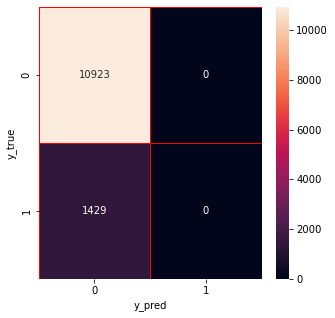

In [12]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='red', fmt='.0f', ax=ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [17]:
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])    
    plt.xlabel('FPR')    
    plt.ylabel('TPR')

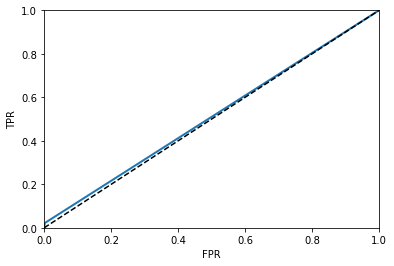

In [18]:
#roc curve 
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_copy)
# fpr, tpr, thresholds
plot_roc_curve(fpr, tpr)

In [19]:
from sklearn.metrics import auc 

auc(fpr, tpr)

0.5100880979369801